In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification
import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
epochs = 40
seed_val = 42
results_window = {}
max_len = 25
stop_at = 5

In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds = []
    history_samples = []
    history_input = []
    history_target = []
    history_index = []
    history_labels = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_texts, train_labels, train_positions, train_target_words = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
        val_texts, val_labels, val_positions, val_target_words = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

        train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
        train_dataset = LexDataset(train_encodings, train_labels, train_positions)

        val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
        val_dataset = LexDataset(val_encodings, val_labels, val_positions)

        train_loader = DataLoader(train_dataset, batch_size=16)
        val_loader = DataLoader(val_dataset, batch_size=1)
        
        all_text = ' '.join(train_texts)
        occurence_text = [all_text.count(w) for w in val_target_words]
        
        occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
        device = torch.device("cuda:1")
        
        model = BertForSharedTaskBaseline.from_pretrained(
            "bert-base-uncased", 
            num_labels = 1, 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(1)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )
        device = torch.device("cuda:1")

        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        
        tracking_metrics = []
        tracking_logits = []
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader, forward_func_custom_bert, optimizer, scheduler)
            training_stats, all_logits, val_metric = evaluate(device, model, val_loader, forward_func_custom_bert)

            tracking_metrics.append(val_metric)
            tracking_logits.append(all_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                early_stopping = 0
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics)
            
        history_labels.extend(val_labels)
        history_preds.extend(tracking_logits[index_min])
        history_samples.extend(val_texts)
        history_input.extend(sentence_raw[val_index])
        history_target.extend(target_words[val_index])
        history_index.extend(([ix_fold] * len(val_index)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results = pd.DataFrame()
    results['samples'] = history_samples
    results['preds'] = history_preds
    results['true_val'] = history_labels
    results['raw'] = history_input
    results['raw'] = results['raw'].astype(str)
    results['target'] = history_target
    results['index'] = history_index
    results['occur_text'] = history_occur_text
    results['occur_target'] = history_occur_target
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 40 ========
Training...

  Average training loss: 0.014260

Running Validation...
  Metric: 0.290591
  Validation Loss: 0.097467

======== Epoch 2 / 40 ========
Training...

  Average training loss: 0.016730

Running Validation...
  Metric: 0.266488
  Validation Loss: 0.082695

======== Epoch 3 / 40 ========
Training...

  Average training loss: 0.015921

Running Validation...
  Metric: 0.253038
  Validation Loss: 0.075177

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.014369

Running Validation...
  Metric: 0.237551
  Validation Loss: 0.066200

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.012204

Running Validation...
  Metric: 0.219598
  Validation Loss: 0.056417

======== Epoch 6 / 40 ========
Training...

  Average training loss: 0.010377

Running Validation...
  Metric: 0.202000
  Validation Loss: 0.048753

======== Epoch 7 / 40 ========
Training...

  Average training loss: 0.010370

Running Validation...
  Me

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 40 ========
Training...

  Average training loss: 0.015298

Running Validation...
  Metric: 0.286595
  Validation Loss: 0.094932

======== Epoch 2 / 40 ========
Training...

  Average training loss: 0.015185

Running Validation...
  Metric: 0.248510
  Validation Loss: 0.072564

======== Epoch 3 / 40 ========
Training...

  Average training loss: 0.016823

Running Validation...
  Metric: 0.263495
  Validation Loss: 0.080516

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.016145

Running Validation...
  Metric: 0.237780
  Validation Loss: 0.066060

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.012457

Running Validation...
  Metric: 0.225111
  Validation Loss: 0.059025

======== Epoch 6 / 40 ========
Training...

  Average training loss: 0.012127

Running Validation...
  Metric: 0.200576
  Validation Loss: 0.048226

======== Epoch 7 / 40 ========
Training...

  Average training loss: 0.011281

Running Validation...
  Me

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 40 ========
Training...

  Average training loss: 0.013028

Running Validation...
  Metric: 0.296554
  Validation Loss: 0.101682

======== Epoch 2 / 40 ========
Training...

  Average training loss: 0.013828

Running Validation...
  Metric: 0.256750
  Validation Loss: 0.077918

======== Epoch 3 / 40 ========
Training...

  Average training loss: 0.015026

Running Validation...
  Metric: 0.237001
  Validation Loss: 0.067055

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.014255

Running Validation...
  Metric: 0.244226
  Validation Loss: 0.070518

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.011574

Running Validation...
  Metric: 0.212850
  Validation Loss: 0.054036

======== Epoch 6 / 40 ========
Training...

  Average training loss: 0.010477

Running Validation...
  Metric: 0.199207
  Validation Loss: 0.047976

======== Epoch 7 / 40 ========
Training...

  Average training loss: 0.009486

Running Validation...
  Me

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskBaseline: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskBaseline from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskBaseline were not initialized from the model checkpoint at bert-base-uncas


======== Epoch 1 / 40 ========
Training...

  Average training loss: 0.021805

Running Validation...
  Metric: 0.259094
  Validation Loss: 0.079024

======== Epoch 2 / 40 ========
Training...

  Average training loss: 0.020538

Running Validation...
  Metric: 0.260056
  Validation Loss: 0.078847

======== Epoch 3 / 40 ========
Training...

  Average training loss: 0.020204

Running Validation...
  Metric: 0.284095
  Validation Loss: 0.091988

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.016645

Running Validation...
  Metric: 0.229845
  Validation Loss: 0.061735

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.013074

Running Validation...
  Metric: 0.220469
  Validation Loss: 0.056676

======== Epoch 6 / 40 ========
Training...

  Average training loss: 0.012741

Running Validation...
  Metric: 0.228465
  Validation Loss: 0.060244

======== Epoch 7 / 40 ========
Training...

  Average training loss: 0.011827

Running Validation...
  Me

In [6]:
print(8)

8


In [7]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [8]:
for window_ix in results_window:
    print('Window of', window_ix)

    mae = results_window[window_ix].groupby(['index']).mae.mean()
    mse = results_window[window_ix].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
MAE --- Mean: 0.0745  Std: 0.0043
MSE --- Mean: 0.009  Std: 0.0009

Window of 1
MAE --- Mean: 0.1154  Std: 0.0653
MSE --- Mean: 0.0237  Std: 0.023

Window of 2
MAE --- Mean: 0.0989  Std: 0.0454
MSE --- Mean: 0.0175  Std: 0.0156



In [11]:
results_window[0].loc[results_window[0].target == 'head']

,samples,preds,true_val,raw,target,index,occur_text,occur_target,mae,mse,discrete_occur
1861,head.,0.150576,0.125000,His left hand is under my head.,head,2,8,4,0.025576,0.000654,2
2755,"head,",0.147263,0.175000,"They each caught his opponent by the head, and...",head,3,9,4,0.027737,0.000769,2
3675,head,0.156474,0.383333,"Do therefore according to your wisdom, and don...",head,4,8,4,0.226859,0.051465,2
5142,head,0.281481,0.173077,"What has happened, Mr President, is that a com...",head,5,8,4,0.108404,0.011751,2
5739,head,0.222213,0.220588,Our findings indicate that huntingtin is requi...,head,6,9,4,0.001625,0.000003,2


In [13]:
results_window[2].loc[results_window[0].target == 'head']

,samples,preds,true_val,raw,target,index,occur_text,occur_target,mae,mse,discrete_occur
1861,under my head.,0.484466,0.125000,His left hand is under my head.,head,2,12,4,0.359466,0.129216,2
2755,"by the head, and thrust",0.162799,0.175000,"They each caught his opponent by the head, and...",head,3,14,4,0.012201,0.000149,2
3675,his gray head go down,0.155224,0.383333,"Do therefore according to your wisdom, and don...",head,4,13,4,0.228110,0.052034,2
5142,post of head of unit,0.229958,0.173077,"What has happened, Mr President, is that a com...",head,5,11,4,0.056881,0.003235,2
5739,"mesoderm and head fold formation,",0.548898,0.220588,Our findings indicate that huntingtin is requi...,head,6,14,4,0.328310,0.107787,2


In [14]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.009375  0.000940  0.074864  0.003649
1               1  0.009928  0.001636  0.077645  0.006479
2               2  0.007791  0.001067  0.070429  0.005244

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.015154  0.014244  0.092968  0.043164
1               1  0.016633  0.018621  0.095524  0.054998
2               2  0.017457  0.018970  0.098778  0.053778

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.017509  0.016041  0.099678  0.046894
1               1  0.016769  0.016287  0.096062  0.047087
2               2  0.017358  0.017350  0.098540  0.050294



In [15]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [16]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


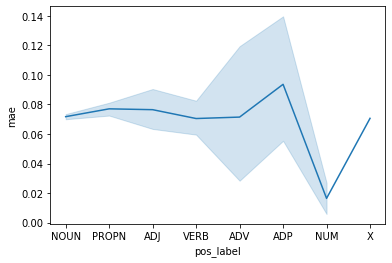

Window size of: 1


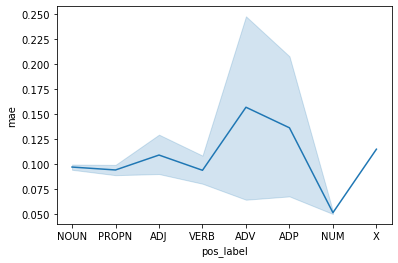

Window size of: 2


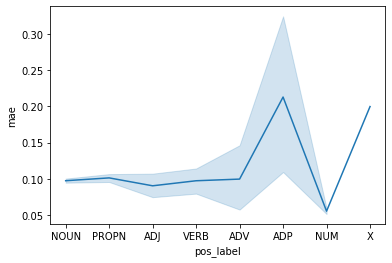

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[results_window[window_ix].pos_label.notnull()], ci=98, markers='o')
    plt.show()

Window size of: 0


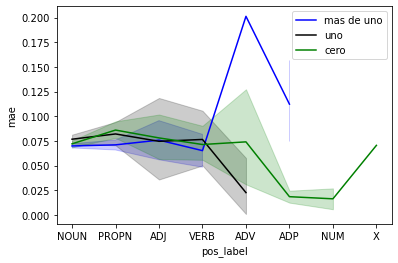

Window size of: 1


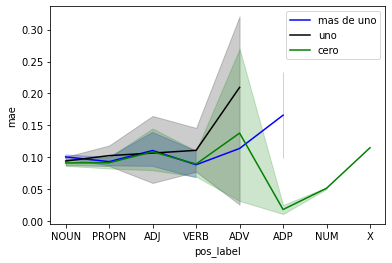

Window size of: 2


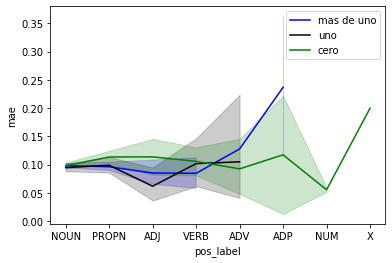

In [18]:
for window_ix in results_window:
    print('Window size of:', window_ix)
    results_many = results_window[window_ix].loc[results_window[window_ix].discrete_occur > 1].reset_index(drop=True)
    results_one = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 1].reset_index(drop=True)
    results_zero = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 0].reset_index(drop=True)
    
    p1 = sns.lineplot(x='pos_label', y='mae', data=results_many.loc[results_many.pos_label.notnull()], ci=98, markers='o', color='blue')
    p2 = sns.lineplot(x='pos_label', y='mae', data=results_one.loc[results_one.pos_label.notnull()], ci=98, markers='o', color='black')
    p3 = sns.lineplot(x='pos_label', y='mae', data=results_zero.loc[results_zero.pos_label.notnull()], ci=98, markers='o', color='green')
    plt.legend(['mas de uno', 'uno', 'cero'])
    plt.show()